# Variance Model: Embedding Variance
Sentence-BERT embeddings at sentence level, compute variance features (mean, std, range, etc.) across sentences per text. GradientBoosting classifier on variance features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from scipy.spatial.distance import cosine
from scipy.stats import entropy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)

sns.set_style('whitegrid')

c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Embeddings
all-MiniLM-L6-v2 encodes sentences, variance features computed per doc.

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

Using device: cuda


Load data from enriched parquet.

In [3]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

print(f'Loaded {len(df)} rows')
print(df['class'].value_counts())

Loaded 1508 rows
class
2    504
3    504
1    500
Name: count, dtype: int64


13 features: consecutive sentence cosine sims, end-start phrase sims, semantic gradient, length bursts, boundary word overlap.

In [4]:
def compute_enhanced_variance_features(text, embedder):
    sentences = sent_tokenize(text)
    
    if len(sentences) < 2:
        return None
    
    sent_embeddings = embedder.encode(sentences, convert_to_numpy=True)
    
    end_start_sims = []
    for i in range(len(sentences) - 1):
        words_i = word_tokenize(sentences[i])
        words_next = word_tokenize(sentences[i + 1])
        
        if len(words_i) >= 2 and len(words_next) >= 2:
            end_phrase = ' '.join(words_i[-3:]) if len(words_i) >= 3 else ' '.join(words_i[-2:])
            start_phrase = ' '.join(words_next[:3]) if len(words_next) >= 3 else ' '.join(words_next[:2])
            
            end_emb = embedder.encode([end_phrase], convert_to_numpy=True)[0]
            start_emb = embedder.encode([start_phrase], convert_to_numpy=True)[0]
            
            sim = 1 - cosine(end_emb, start_emb)
            end_start_sims.append(sim)
    
    full_sims = []
    for i in range(len(sent_embeddings) - 1):
        sim = 1 - cosine(sent_embeddings[i], sent_embeddings[i + 1])
        full_sims.append(sim)
    
    gradients = []
    if len(full_sims) >= 2:
        for i in range(len(full_sims) - 1):
            grad = abs(full_sims[i + 1] - full_sims[i])
            gradients.append(grad)
    
    sentence_lengths = [len(word_tokenize(s)) for s in sentences]
    length_diffs = [abs(sentence_lengths[i+1] - sentence_lengths[i]) for i in range(len(sentence_lengths)-1)]
    
    boundary_repetitions = []
    for i in range(len(sentences) - 1):
        words_i = set(word_tokenize(sentences[i].lower()))
        words_next = set(word_tokenize(sentences[i + 1].lower()))
        overlap = len(words_i.intersection(words_next)) / max(len(words_i.union(words_next)), 1)
        boundary_repetitions.append(overlap)
    
    features = {
        'n_sentences': len(sentences),
        'avg_full_sim': np.mean(full_sims) if full_sims else 0,
        'std_full_sim': np.std(full_sims) if full_sims else 0,
        'min_full_sim': np.min(full_sims) if full_sims else 0,
        'max_full_sim': np.max(full_sims) if full_sims else 0,
        'avg_end_start_sim': np.mean(end_start_sims) if end_start_sims else 0,
        'std_end_start_sim': np.std(end_start_sims) if end_start_sims else 0,
        'avg_gradient': np.mean(gradients) if gradients else 0,
        'max_gradient': np.max(gradients) if gradients else 0,
        'avg_length_diff': np.mean(length_diffs) if length_diffs else 0,
        'std_length_diff': np.std(length_diffs) if length_diffs else 0,
        'avg_boundary_overlap': np.mean(boundary_repetitions) if boundary_repetitions else 0,
        'std_boundary_overlap': np.std(boundary_repetitions) if boundary_repetitions else 0,
    }
    
    return features

test_features = compute_enhanced_variance_features(df.iloc[0]['text'], embedder)
for k, v in test_features.items():
    print(f'  {k}: {v:.4f}')

  n_sentences: 7.0000
  avg_full_sim: 0.3430
  std_full_sim: 0.1209
  min_full_sim: 0.1376
  max_full_sim: 0.5477
  avg_end_start_sim: 0.1611
  std_end_start_sim: 0.0375
  avg_gradient: 0.1221
  max_gradient: 0.2072
  avg_length_diff: 16.1667
  std_length_diff: 9.1727
  avg_boundary_overlap: 0.1435
  std_boundary_overlap: 0.0390


Apply to all texts.

In [5]:
all_features = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = compute_enhanced_variance_features(row['text'], embedder)
    if features is not None:
        all_features.append(features)
        valid_indices.append(idx)

features_df = pd.DataFrame(all_features)
df_valid = df.loc[valid_indices].reset_index(drop=True)
df_valid = pd.concat([df_valid, features_df], axis=1)
print(f'{len(df_valid)} texts')

  0%|          | 0/1508 [00:00<?, ?it/s]

100%|██████████| 1508/1508 [05:24<00:00,  4.64it/s]


1508 texts


## Train/val split and model
Stratified 70/15/15 split, GradientBoosting with 200 trees.

In [6]:
df_valid['strat_key'] = df_valid['class'].astype(str) + '_' + df_valid['author'].astype(str)

train_val, test = train_test_split(df_valid, test_size=0.15, stratify=df_valid['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

print(f'Train: {len(train)}, Val: {len(val)}, Test: {len(test)}')

train[['id', 'class', 'topic', 'author']].to_parquet('train.parquet', index=False)
val[['id', 'class', 'topic', 'author']].to_parquet('validate.parquet', index=False)
test[['id', 'class', 'topic', 'author']].to_parquet('test.parquet', index=False)

Train: 1054, Val: 227, Test: 227


Prepare feature arrays and scale.

In [7]:
feature_cols = ['n_sentences', 'avg_full_sim', 'std_full_sim', 'min_full_sim', 'max_full_sim',
                'avg_end_start_sim', 'std_end_start_sim', 'avg_gradient', 'max_gradient',
                'avg_length_diff', 'std_length_diff', 'avg_boundary_overlap', 'std_boundary_overlap']

X_train = train[feature_cols].values
y_train = (train['class'] > 1).astype(int).values

X_val = val[feature_cols].values
y_val = (val['class'] > 1).astype(int).values

X_test = test[feature_cols].values
y_test = (test['class'] > 1).astype(int).values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Features: {feature_cols}')

Features: ['n_sentences', 'avg_full_sim', 'std_full_sim', 'min_full_sim', 'max_full_sim', 'avg_end_start_sim', 'std_end_start_sim', 'avg_gradient', 'max_gradient', 'avg_length_diff', 'std_length_diff', 'avg_boundary_overlap', 'std_boundary_overlap']


Fit GradientBoosting, evaluate on val.

In [8]:
model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_val_prob = model.predict_proba(X_val_scaled)[:, 1]
y_val_pred = model.predict(X_val_scaled)

val_auc = roc_auc_score(y_val, y_val_prob)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Validation ROC AUC: {val_auc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation ROC AUC: 0.8564
Validation Accuracy: 0.7841


## Feature importance and analysis

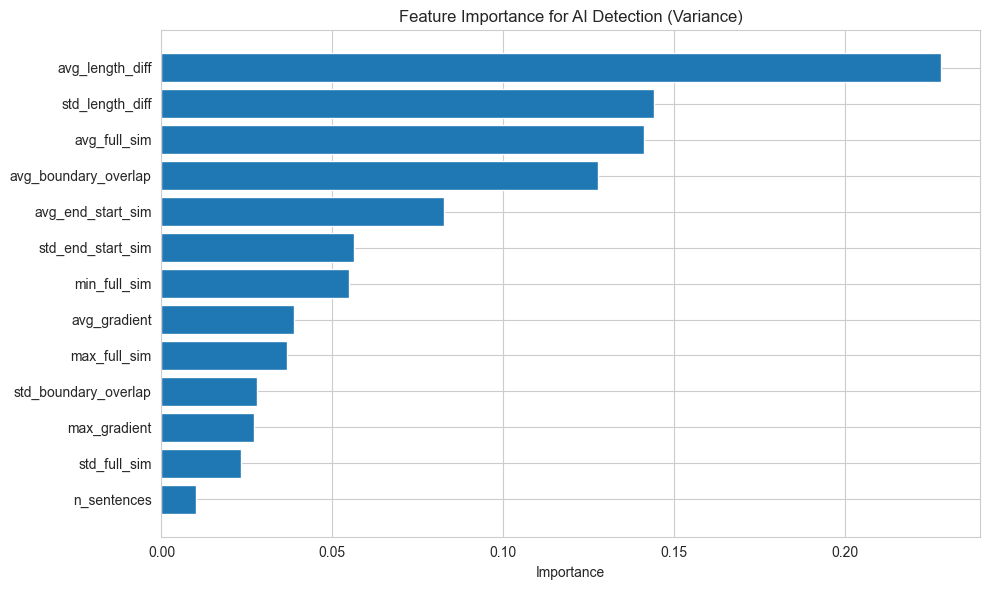


Top Features:
  avg_length_diff: 0.2283
  std_length_diff: 0.1443
  avg_full_sim: 0.1413
  avg_boundary_overlap: 0.1280
  avg_end_start_sim: 0.0829


In [9]:
importance = model.feature_importances_
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'])
ax.set_xlabel('Importance')
ax.set_title('Feature Importance for AI Detection (Variance)')
plt.tight_layout()
plt.show()

print('\nTop Features:')
for _, row in importance_df.sort_values('importance', ascending=False).head(5).iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

ROC curves by author and topic.

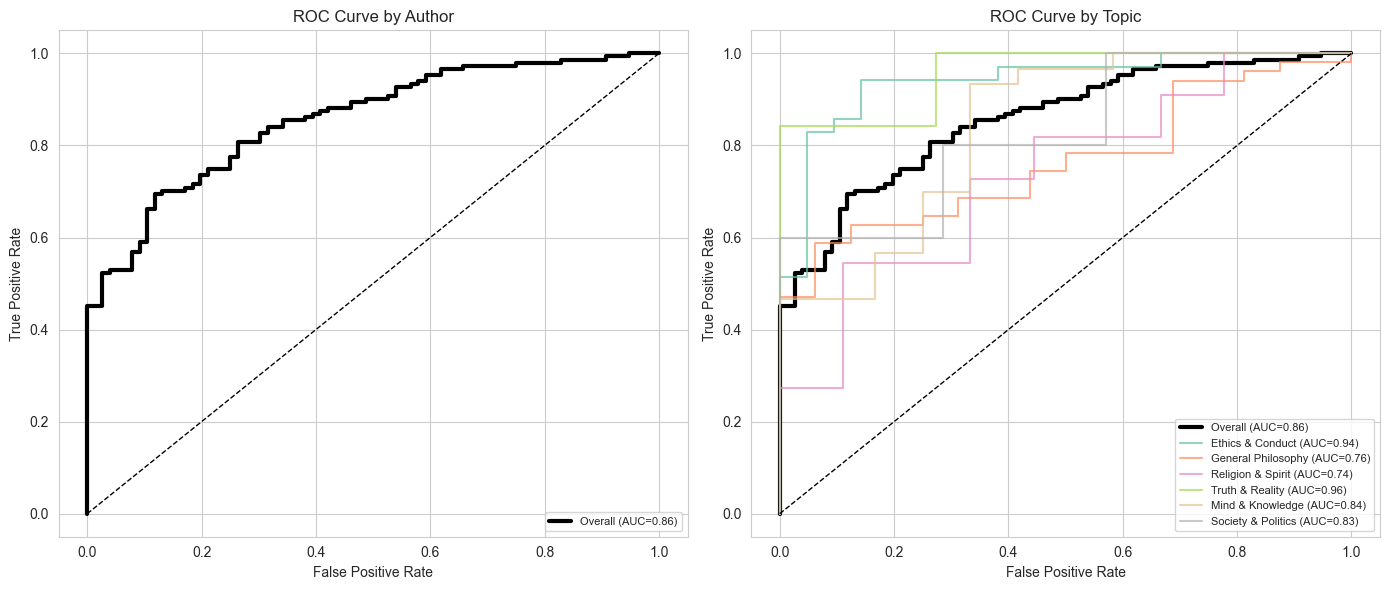

In [10]:
val_results = val.copy()
val_results['prob_ai'] = y_val_prob
val_results['pred'] = y_val_pred
val_results['actual_binary'] = y_val

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr, tpr, _ = roc_curve(y_val, y_val_prob)

ax1 = axes[0]
ax1.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={val_auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve by Author')
ax1.legend(loc='lower right', fontsize=8)

ax2 = axes[1]
ax2.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={val_auc:.2f})')

colors_t = plt.cm.Set2(np.linspace(0, 1, len(val_results['topic'].unique())))
for i, topic in enumerate(val_results['topic'].unique()):
    mask = val_results['topic'] == topic
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax2.plot(fpr_sub, tpr_sub, color=colors_t[i], lw=1.5, alpha=0.7,
                     label=f'{topic} (AUC={auc_sub:.2f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve by Topic')
ax2.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

Feature distributions by class.

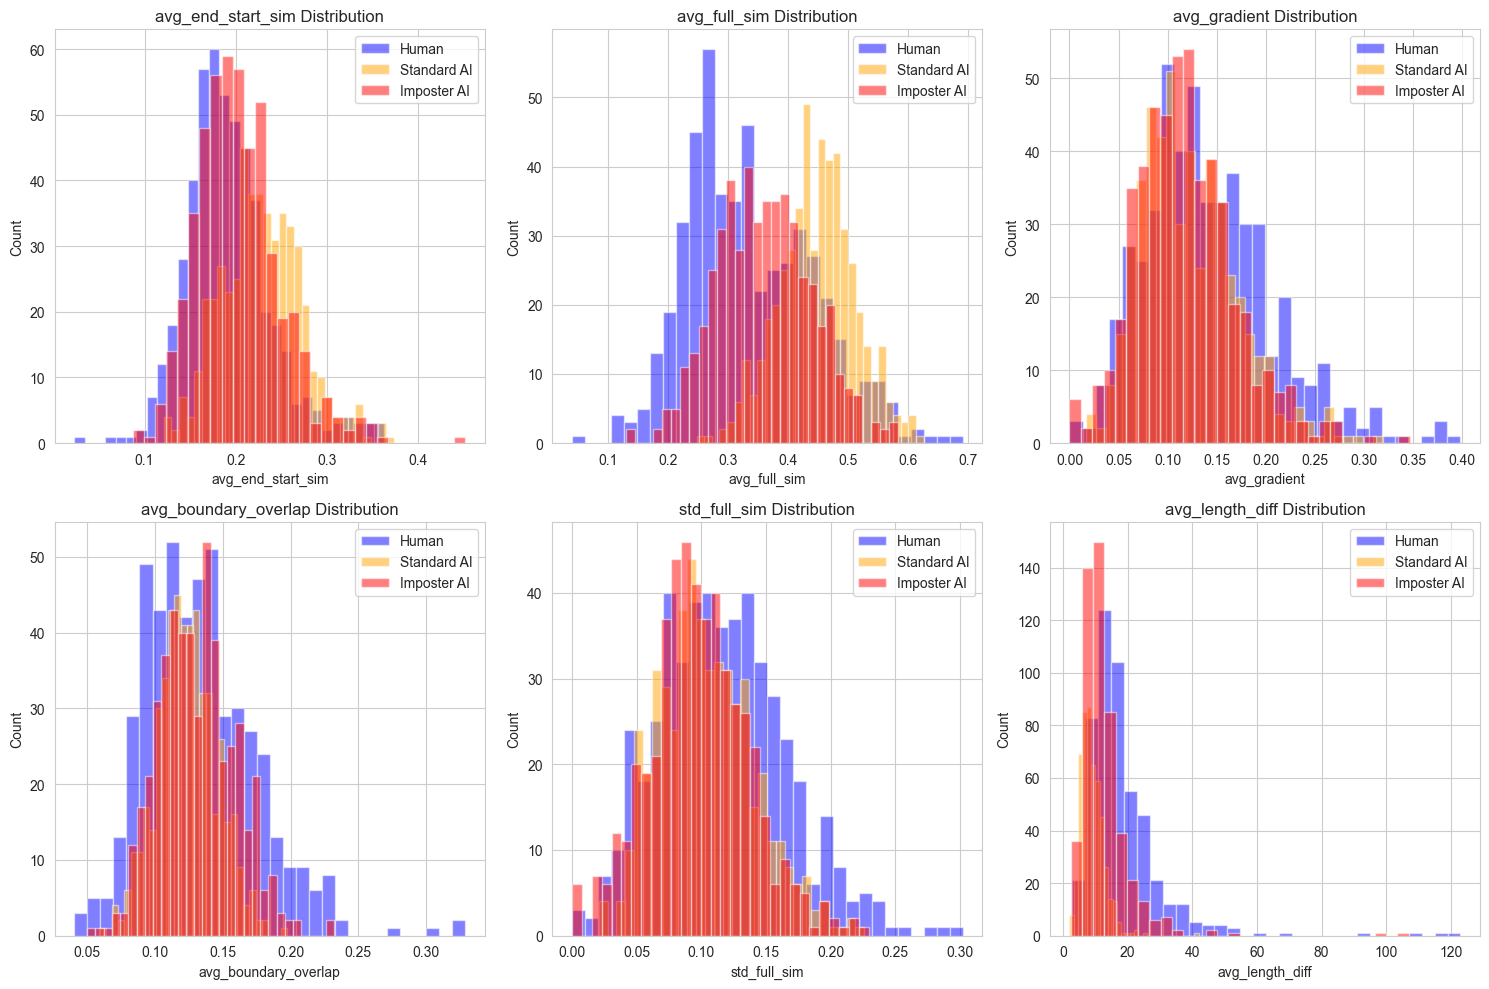

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

key_features = ['avg_end_start_sim', 'avg_full_sim', 'avg_gradient', 
                'avg_boundary_overlap', 'std_full_sim', 'avg_length_diff']

for ax, feat in zip(axes.flatten(), key_features):
    for cls, label, color in [(1, 'Human', 'blue'), (2, 'Standard AI', 'orange'), (3, 'Imposter AI', 'red')]:
        mask = df_valid['class'] == cls
        ax.hist(df_valid[mask][feat], bins=30, alpha=0.5, label=label, color=color)
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'{feat} Distribution')

plt.tight_layout()
plt.show()

## Test set

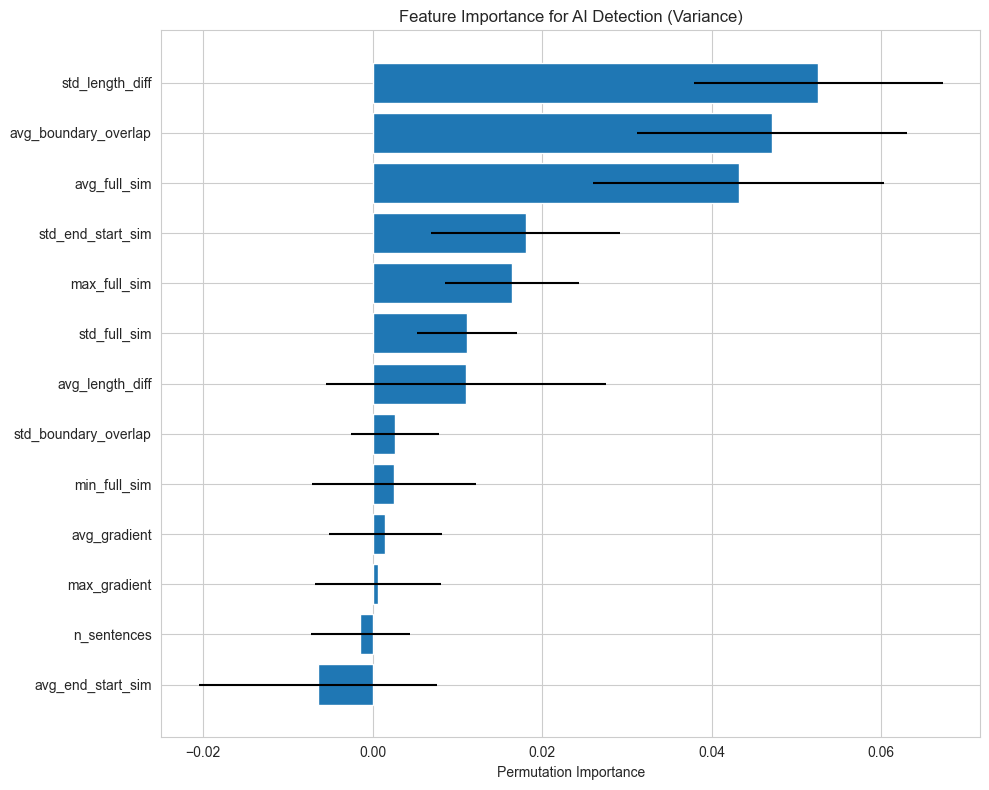

- max_full_sim: 0.0164 +/- 0.0080
- std_end_start_sim: 0.0181 +/- 0.0112
- avg_full_sim: 0.0432 +/- 0.0172
- avg_boundary_overlap: 0.0471 +/- 0.0159
- std_length_diff: 0.0526 +/- 0.0147


In [12]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=30, random_state=42)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
ax.set_xlabel('Permutation Importance')
ax.set_title('Feature Importance for AI Detection (Variance)')
plt.tight_layout()
plt.show()

top_features = importance_df.tail(5)
for _, row in top_features.iterrows():
    print(f"- {row['feature']}: {row['importance_mean']:.4f} +/- {row['importance_std']:.4f}")

Error analysis on val set.

In [13]:
val_results['error'] = val_results['pred'] != val_results['actual_binary']
val_results['error_type'] = 'Correct'
val_results.loc[(val_results['actual_binary'] == 0) & (val_results['pred'] == 1), 'error_type'] = 'Human→AI (FP)'
val_results.loc[(val_results['actual_binary'] == 1) & (val_results['pred'] == 0), 'error_type'] = 'AI→Human (FN)'

print('Error Distribution:')
print(val_results['error_type'].value_counts())

fp_samples = val_results[val_results['error_type'] == 'Human→AI (FP)'].head(3)
print('\n' + '='*50)
print('Humans Misclassified as AI:')
print('='*50)
for idx, row in fp_samples.iterrows():
    print(f'\nID: {row["id"]}, Author: {row["author"]}, Prob(AI): {row["prob_ai"]:.3f}')
    print(f'Text preview: {row["text"][:300]}...')
    print('-'*30)

Error Distribution:
error_type
Correct          178
AI→Human (FN)     26
Human→AI (FP)     23
Name: count, dtype: int64

Humans Misclassified as AI:

ID: a32af5ab-bb4e-4d65-b301-b6d350a4be82, Author: Emerson, Prob(AI): 0.737
Text preview: This gentleman is this afternoon arrived from Denmark; and that is my Lord Ride, who came yesterday from Bagdad; here is Captain Friese, from Cape Turnagain, and Captain Symmes, from the interior of the earth; and Monsieur Jovaire, who came down this morning in a balloon; Mr. Hobnail, the reformer; ...
------------------------------

ID: f44fe36f-6401-4158-9392-9543f023818e, Author: Russell, Prob(AI): 0.966
Text preview: Further, it is probable, though not certain, that we have acquaintance with Self, as that which is aware of things or has desires towards things. In addition to our acquaintance with particular existing things, we also have acquaintance with what we shall call universals, that is to say, general ide...
------------------------------



Test set evaluation and confusion matrix.

Test ROC AUC: 0.8409
Test Accuracy: 0.7577


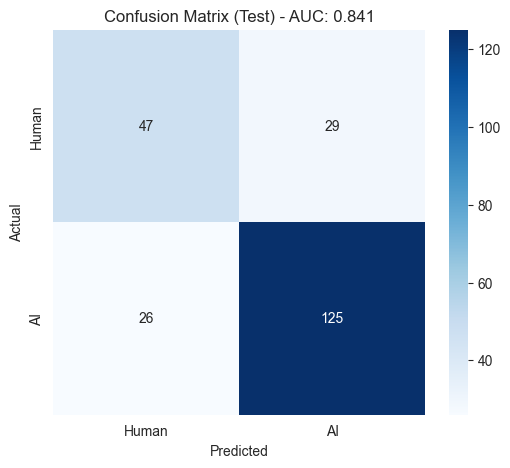

In [14]:
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = model.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_prob)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test ROC AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (Test) - AUC: {test_auc:.3f}')
plt.show()